## Final Project - Predictive Maintenance for Aircraft Engines

Lihua Pei<br>
Lujin Lu <br>
Olatunji Akinbule <br>

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
from problem import get_train_data,  get_test_data



from sklearn.preprocessing import StandardScaler
#from sklearn.metrics import confusion_matrix
#from sklearn.metrics import accuracy_score , auc, classification_report, precision_score,recall_score,log_loss, roc_curve

from itertools import cycle
from sklearn.preprocessing import label_binarize
from scipy import interp
sns.set(font_scale=1.0)

In [6]:
# Load train data
X_train_data , y_train = get_train_data()
X_train_data.shape , y_train.shape

X_test_data, y_test = get_test_data()
print(X_test_data.shape , y_test.shape)
print(X_train_data.head(3))



(29692, 26) (29692,)
   ID  Cycle  op_set_1  op_set_2  op_set_3      s1      s2       s3       s4  \
0   1      1   -0.0007   -0.0004     100.0  518.67  641.82  1589.70  1400.60   
1   1      2    0.0019   -0.0003     100.0  518.67  642.15  1591.82  1403.14   
2   1      3   -0.0043    0.0003     100.0  518.67  642.35  1587.99  1404.20   

      s5   ...        s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62   ...     521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62   ...     522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62   ...     522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  

[3 rows x 26 columns]


The data consist of 45351 observations and 26 features. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:

1) Unit number or ID of the engine ( 200 unique IDs)

2) Time in cycles

3) to 5) Operational settings 1 to 3

6) to 26) Sensor measurements 1 to 21

These measurements include various sensor response surfaces and operability margins :

s1: Total temperature at fan inlet <br>
s2: Total temperature at LPC outlet <br>
s3 : Total temperature at HPC (High-Pressure Compressor) outlet <br>
s4: Total temperature at LPT outlet <br>
s5: Pressure at fan inlet <br>
s6 : Total pressure in bypass-duct <br>
s7 :Total pressure at HPC outlet <br>
s8: Physical fan speed <br>
s9 :Physical core speed <br>
s10: Engine pressure ratio (P50/P2) <br>
s11: Static pressure at HPC outlet <br>
s12: Ratio of fuel flow to Ps30 <br>
s13: Corrected fan speed <br>
s14: Corrected core speed <br>
s15: Bypass Ratio <br>
s16: Burner fuel-air ratio <br>
s17: Bleed Enthalpy <br>
s18: Demanded fan speed <br>
s19: Demanded corrected fan speed <br>
s20: HPT coolant bleed <br>
s21: LPT coolant bleed <br>

In [7]:
# Rename Column headers    
X_train_columns = X_train_data.columns 
    
new_Xtrain_columns = ['engine_id', 'cycle', 'op_set_1', 'op_set_2', 'op_set_3','fan_inlet_temp', 'total_temp_LPC_outliet', 
              'total_temp_HPC_outliet','total_temp_LPT_outliet' , 'fan_inlet_pressure', 'total_pressure_bypass_duct',
              'total_pressure_hpc_outlet', 'physical_fan_speed', 'physical_core_speed', 'engine_pressure_ratio',
              'static_pressure_HPC_outlet', 'fuel_flow_ratio', 'corrected_fan_speed', 'corrected_core_speed',
              'bypass_ratio', 'burner_fuel_air_ratio', 'bleedy_enthalpy', 'demanded_fan_speed', 'demanded_corrected_fan_speed',
              'HPT_coolant_bleed', 'LPT_coolant_bleed']


rename_columns_dictionary = dict(zip(X_train_columns, new_Xtrain_columns ))

X_train_data.rename(columns = rename_columns_dictionary, inplace = True)

print(X_train_data.head(3))

   engine_id  cycle  op_set_1  op_set_2  op_set_3  fan_inlet_temp  \
0          1      1   -0.0007   -0.0004     100.0          518.67   
1          1      2    0.0019   -0.0003     100.0          518.67   
2          1      3   -0.0043    0.0003     100.0          518.67   

   total_temp_LPC_outliet  total_temp_HPC_outliet  total_temp_LPT_outliet  \
0                  641.82                 1589.70                 1400.60   
1                  642.15                 1591.82                 1403.14   
2                  642.35                 1587.99                 1404.20   

   fan_inlet_pressure        ...          fuel_flow_ratio  \
0               14.62        ...                   521.66   
1               14.62        ...                   522.28   
2               14.62        ...                   522.42   

   corrected_fan_speed  corrected_core_speed  bypass_ratio  \
0              2388.02               8138.62        8.4195   
1              2388.07               8131.49 

## Exploratory Data Analysis

Multi-class classification problem and we define 4 four Time to Failure windows (4 classes) :

<b>Class 0</b> : Very urgent maintenance : 0 to 10 cycles remaining before failure.<br>
<b>Class 1</b> : Aircraft maintenance periodic checks need to be deep and more detailed : 11 to 30 cycles remaining before failure.<br>
<b>Class 2</b> : Confident system : We can plan from this period the future maintenance date and provide the needed equipments : 31 to 100 cycles remaining before failure. <br>
<b>Class 3</b>: Very confident system : Only periodic checks are needed : more than 101cycles remaining before failure.<br>

In [8]:
# Target Labels consisting 4 classes representing Time to Failure windows
y_train.unique()

array([3, 2, 1, 0], dtype=int64)

Text(0.5, 1.0, 'Number of observation per class ')

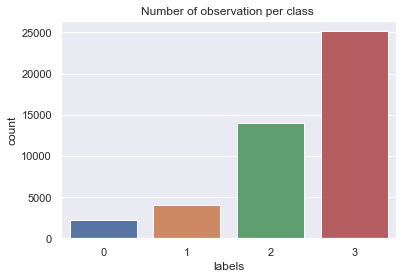

In [9]:
# Concatenating X_train_data and y_train for visualization
X_train_data_df = X_train_data
y = pd.DataFrame(y_train)
X_train_data_df['labels'] = y['labels'].values


# Target Observations per Class
ax= sns.countplot(x='labels', data=X_train_data_df)
plt.title("Number of observation per class ")

# Distribution between classes is imbalanced

Text(0.5, 1.0, 'Distribution of engines with respect to their failure cycles')

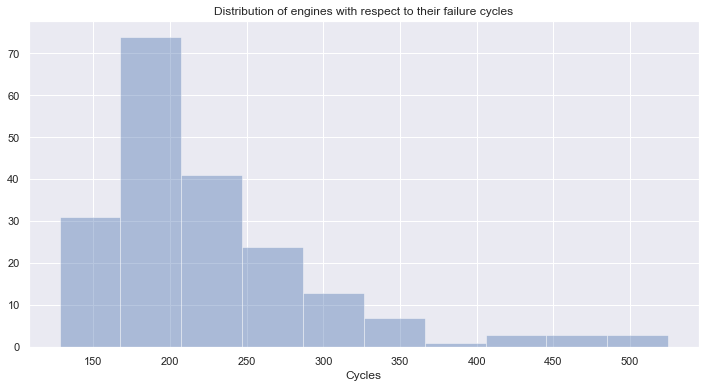

In [10]:
# Distribution of all engines with a focus on their failure cycle
cycles_per_engine = pd.DataFrame(X_train_data.groupby('engine_id')['cycle'].max())
cycles_per_engine.reset_index(level = 0 , inplace=True)
cycles_per_engine.columns = ['engine_id' , 'Cycles']
plt.figure(figsize=(12,6))
sns.distplot(cycles_per_engine.Cycles , bins= 10, kde=False)
plt.title("Distribution of engines with respect to their failure cycles")

<b>Based on the distribution 75% of the engines fail before reaching 256 cycles

In [11]:
# Determine statistics on Cycles for each engine
print(cycles_per_engine.Cycles.quantile(0.75)) 



256.25


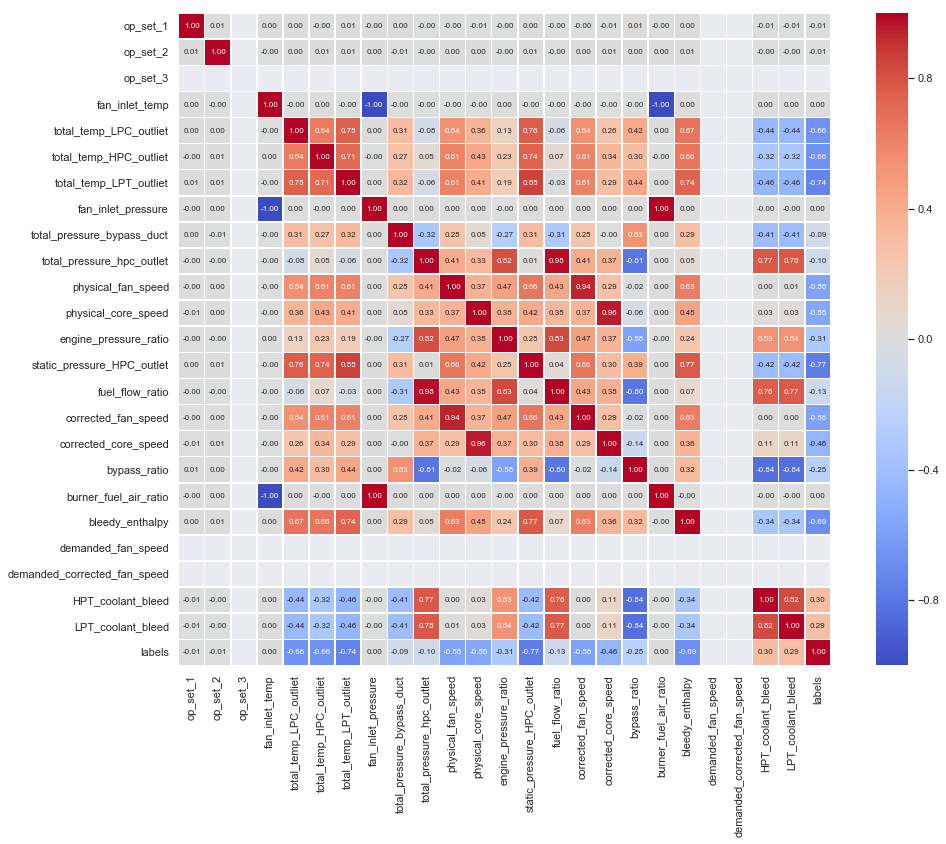

In [12]:
# Plot feature correlation matrix

feature_corr = X_train_data_df.iloc[:,2:].corr()
plt.figure(figsize=(16,12))
sns.heatmap(feature_corr,annot=True,square=True,fmt='.2f',annot_kws={'size':8}, cmap='coolwarm',linewidths=.5)
plt.show()

<b>Empty values above due to NA values present in the specified features

In [13]:
## Correlation matrix shows empty fields with variables op_set_3, demanded_fan_speed, demanded_corrected_fan_speed due to NA values
# removing features with NA values to exclude empty lines in correlation matrix
X_train = X_train_data.drop(['engine_id', 'labels','demanded_fan_speed', 'demanded_corrected_fan_speed','op_set_3'],axis=1)


# remove features with 0 correlation with target as they will have no bearing on the result
X_train.drop(['op_set_1','op_set_2','fan_inlet_temp','fan_inlet_pressure','burner_fuel_air_ratio'], axis=1, inplace = True)

In [14]:
X_train.columns

Index(['cycle', 'total_temp_LPC_outliet', 'total_temp_HPC_outliet',
       'total_temp_LPT_outliet', 'total_pressure_bypass_duct',
       'total_pressure_hpc_outlet', 'physical_fan_speed',
       'physical_core_speed', 'engine_pressure_ratio',
       'static_pressure_HPC_outlet', 'fuel_flow_ratio', 'corrected_fan_speed',
       'corrected_core_speed', 'bypass_ratio', 'bleedy_enthalpy',
       'HPT_coolant_bleed', 'LPT_coolant_bleed'],
      dtype='object')

<b>Drop one of highly correlated features pairings (> 0.9)

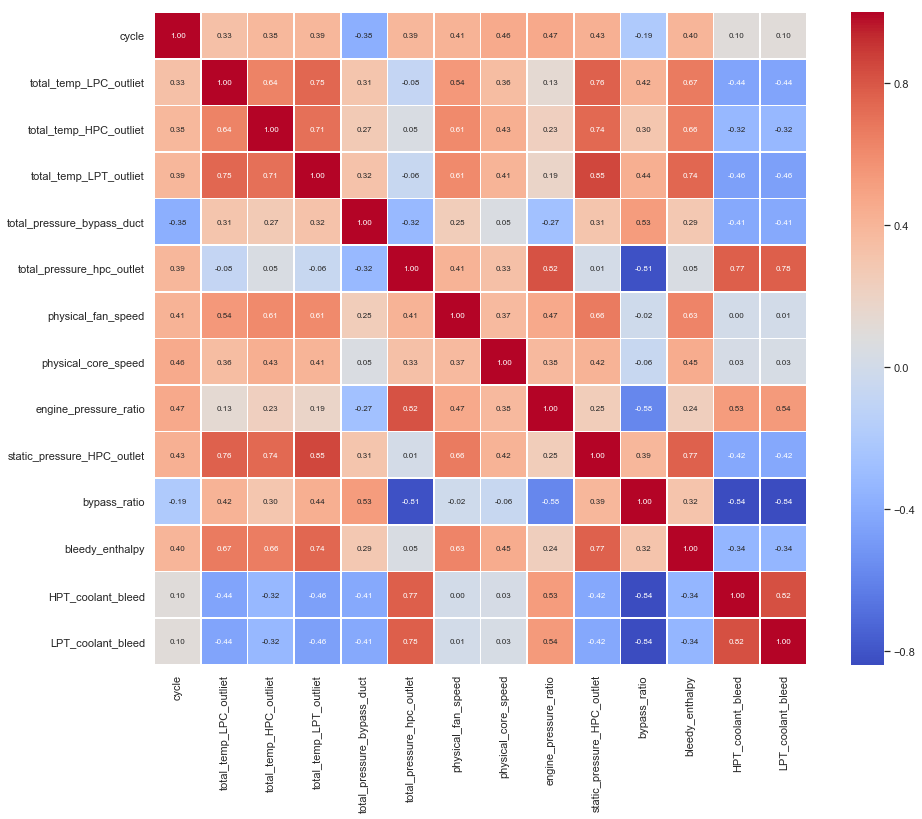

In [15]:
# Correlations
#s5 - s16= 1
#s7 - s12 = 0.95
#s8 - s13 = 0.94
#s9 - s14 = 0.95

X_train.drop(['fuel_flow_ratio','corrected_fan_speed','corrected_core_speed'], axis=1,inplace=True)

feature_corr = X_train.iloc[:,:].corr()
plt.figure(figsize=(16,12))
sns.heatmap(feature_corr,annot=True,square=True,fmt='.2f',annot_kws={'size':8}, cmap='coolwarm',linewidths=.5)
plt.show()

In [ ]:
# Include pair plot for all remaining values or maybe values before ::: run

ft_to_pairplot=['total_temp_LPC_outliet','total_temp_HPC_outliet','total_temp_LPT_outliet','physical_fan_speed','physical_core_speed','static_pressure_HPC_outlet','bleedy_enthalpy', 'labels']
g = sns.PairGrid(X_train_data[ft_to_pairplot], hue="labels", vars=ft_to_pairplot[:-1])
g = g.map_diag(plt.hist, histtype="step", linewidth=3)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot)
g = g.add_legend()

## Principal Component Analysis

************Eigenvalues (All Features) ************
 :[5.76333358 4.30021406 1.06751319 0.66835633 0.36126936 0.34412181
 0.30709991 0.26895409 0.21931205 0.18648296 0.17798461 0.1393024
 0.13824861 0.05811573]


************Cumulative Percentage Variance Explained (All Features) ************
[ 41.17  71.89  79.51  84.28  86.86  89.32  91.51  93.43  95.    96.33
  97.6   98.59  99.58 100.  ]




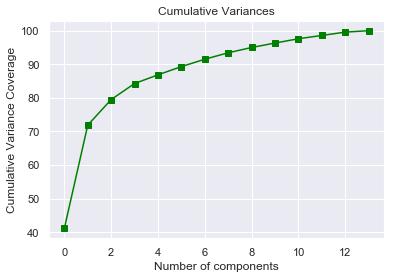

In [16]:
# Standardize Data

X_train_std = StandardScaler().fit_transform(X_train.astype(float))



# PCA - All features
from sklearn.decomposition import PCA
n = len(X_train.columns)
pca_all = PCA(n_components=n)

pca_all.fit(X_train_std)

# Eigenvalues for all features:
eigen_all=pca_all.explained_variance_

#The amount of variance that each Principal Component
var_all= pca_all.explained_variance_ratio_

# Cumulative Variance explains
var1_all=np.cumsum(np.round(pca_all.explained_variance_ratio_, decimals=4)*100)

print(f"************Eigenvalues (All Features) ************\n :{eigen_all}\n")
print()

print(f"************Cumulative Percentage Variance Explained (All Features) ************\n{var1_all}\n")
print()

plt.plot(var1_all, color='green', marker ='s', label='all')
plt.title("Cumulative Variances")
plt.xlabel("Number of components")
plt.ylabel("Cumulative Variance Coverage")
plt.show()


# Draw line y = 1
horizontal_line = np.array([1] * n)

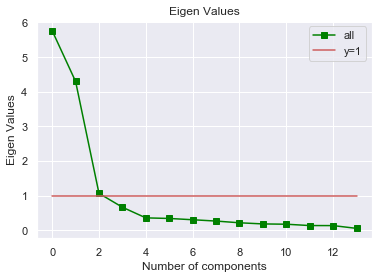

In [17]:
plt.plot(eigen_all, color='green', marker ='s',  label='all')
plt.plot(horizontal_line, color='indianred', label='y=1')
plt.legend(loc='upper right')
plt.title("Eigen Values")
plt.xlabel("Number of components")
plt.ylabel("Eigen Values")
plt.show()


#### 2D Loading Plots

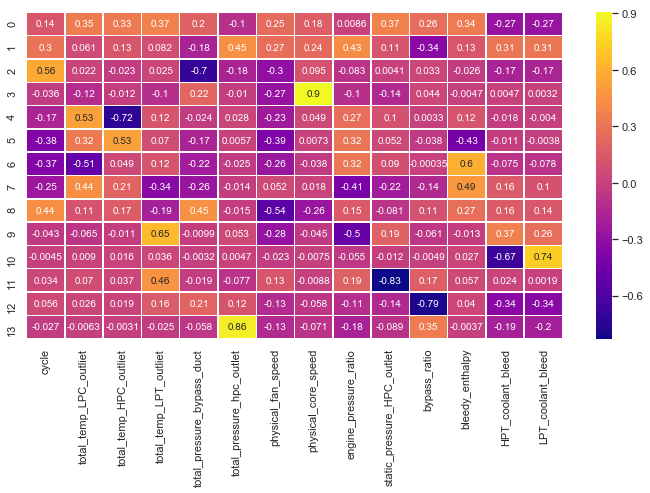

In [18]:
# Make a dataframe of eigenvectors and examine top 3
eigenvectors = pd.DataFrame(pca_all.components_, columns = X_train.columns)
#print(eigenvectors.head(3))

# Show heatmap of eigenvectors
plt.figure(figsize=(12,6))
sns.heatmap(eigenvectors,cmap='plasma', linewidths = .5, annot = True)

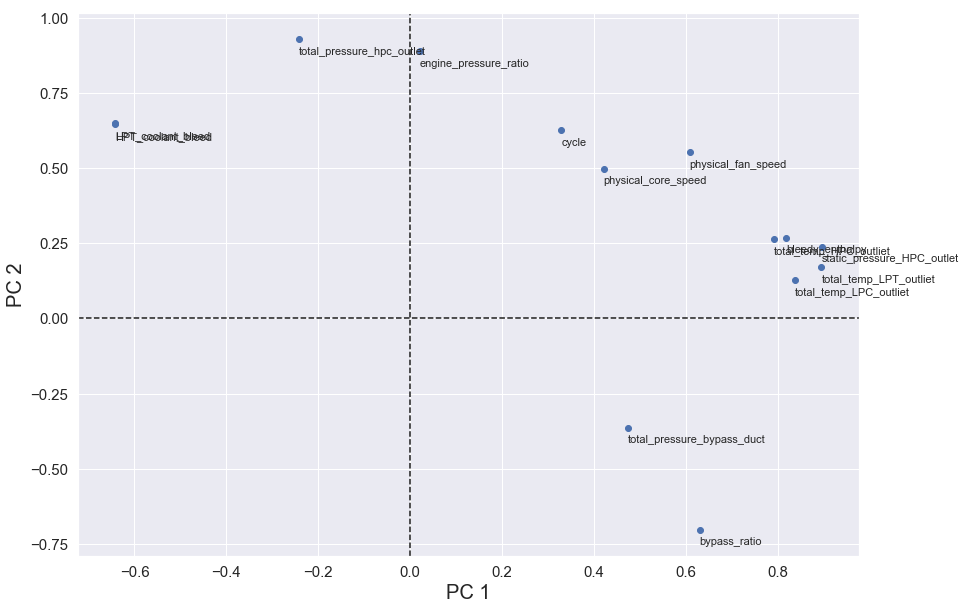

In [19]:
# Calculate and explore loadings to pick up any possible patterns in the limitation of a 2D view

pca_loading = eigenvectors.T * np.sqrt(pca_all.explained_variance_)


  
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(pca_loading[0], pca_loading[1])

#ax.set_title('Loading Plots', fontsize=20)

ax.set_xlabel('PC 1', fontsize=20)
ax.set_ylabel('PC 2', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--')
#plt.rcParams.update({'font.size': 11})

for i, f in zip(range(16), X_train.columns):
    ax.annotate(f, (pca_loading[0].iloc[i],pca_loading[1].iloc[i]-0.05), size = 11)

plt.show()

# Write loadings out for analysis
loading_df = pd.DataFrame(pca_loading)

# Show heatmap of loading
# plt.figure(figsize=(12,6))
# sns.heatmap(loading_df,cmap='plasma', linewidths = .5, annot = True)

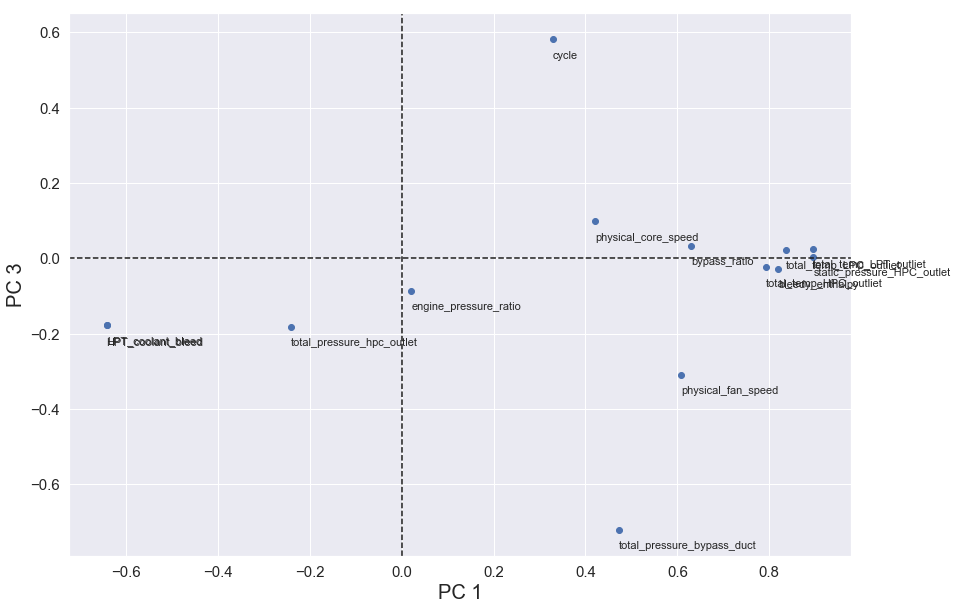

In [20]:
  
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(pca_loading[0], pca_loading[2])

#ax.set_title('Loading Plots', fontsize=20)

ax.set_xlabel('PC 1', fontsize=20)
ax.set_ylabel('PC 3', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--')
#plt.rcParams.update({'font.size': 11})

for i, f in zip(range(16), X_train.columns):
    ax.annotate(f, (pca_loading[0].iloc[i],pca_loading[2].iloc[i]-0.05), size = 11)

plt.show()

# Write loadings out for analysis
loading_df = pd.DataFrame(pca_loading)

# Show heatmap of loading
# plt.figure(figsize=(12,6))
# sns.heatmap(loading_df,cmap='plasma', linewidths = .5, annot = True)

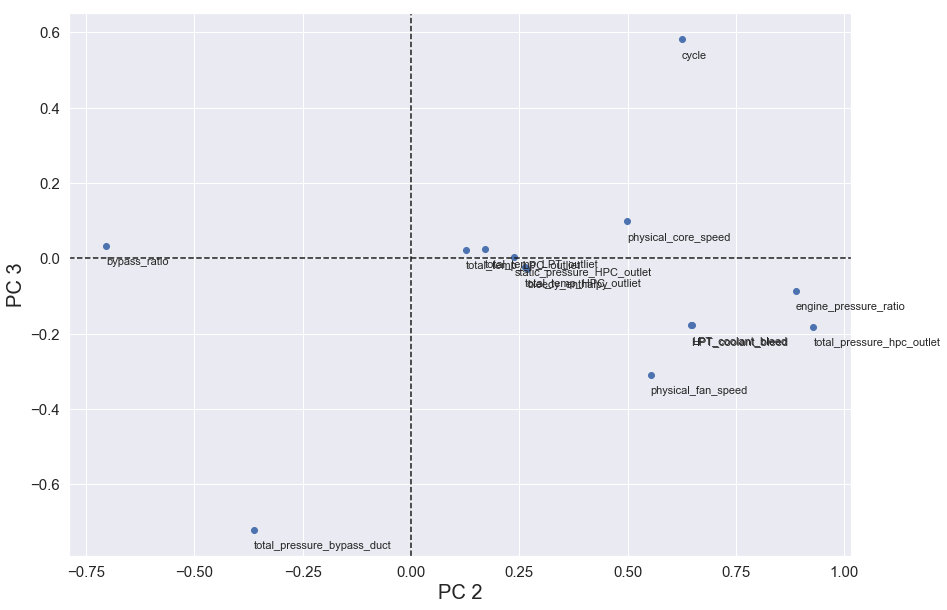

In [21]:
  
fig = plt.figure(figsize=(14, 10))
ax = fig.add_subplot(1, 1, 1)

ax.scatter(pca_loading[1], pca_loading[2])

#ax.set_title('Loading Plots', fontsize=20)

ax.set_xlabel('PC 2', fontsize=20)
ax.set_ylabel('PC 3', fontsize=20)
ax.xaxis.set_tick_params(labelsize=15)
ax.yaxis.set_tick_params(labelsize=15)
ax.axvline(0, color='k', linestyle='--')
ax.axhline(0, color='k', linestyle='--')
#plt.rcParams.update({'font.size': 11})

for i, f in zip(range(16), X_train.columns):
    ax.annotate(f, (pca_loading[1].iloc[i],pca_loading[2].iloc[i]-0.05), size = 11)

plt.show()

# Write loadings out for analysis
loading_df = pd.DataFrame(pca_loading)

# Show heatmap of loading
# plt.figure(figsize=(12,6))
# sns.heatmap(loading_df,cmap='plasma', linewidths = .5, annot = True)

## Inferences on Principal Components

In [ ]:
"""
The First Principal Component appears to be composed of the heating factor. The high performing engines can handle the 
engine workload without inflating the high temperature principal component 1 heating factor

It weighs the s2, 23, s4, S17 relatively equally

The Second Principal Component appears to be composed of ...
It weights the s7, s10, s15 (negative), s20, s21, labels(negatively) relatively equally

The Third Principal Component appears to be composed of ....
It weights the Cycle and s6 (negatively) relatively equally
""" 

## 3D Plots 

#### Plot of Cycles against Principal Components

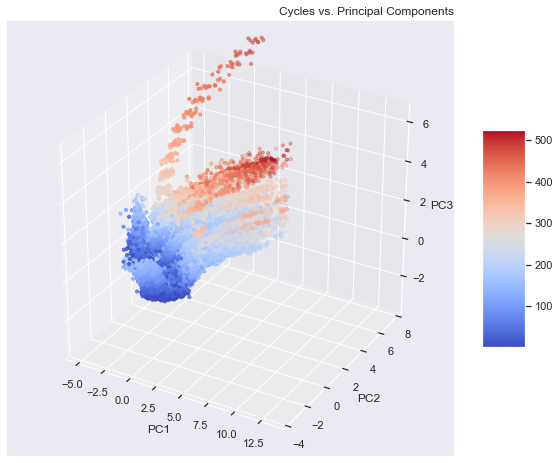

In [22]:
# Make dataframe for principal components 
# Projection of the original data to the PCA space
Y = pd.DataFrame(pca_all.fit_transform(X_train_std), columns = ['PC{}'.format(str(i)) for i in range(0,14)])


import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'],
    zdir='x', s = 10, c = X_train['cycle'], # select cycles to plot against the first 3 principal components
    cmap = 'coolwarm', depthshade=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Cycles vs. Principal Components", loc ='right')
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()

In [ ]:
# **** Identify specific engines to gain intuition ********
# Visual insights from 3D plot of cycles against eigenvectors

"""
The 3rd Principal components is heavily weighted on the 'cycle' vector (positive 0.56 compared to all other features) 
in the PCA space

We identified the highest performing aircraft engines based on the resultant Time to Failure (TFF results) 
after undergoing the highest number of cycles and then visualize their cartesian positioning in the 3D plot above and replot. 

This is to understand the visual relationship between the best engines and our first 3 principal components
"""


In [23]:
# include engine_id back into X_train data

#v = X_train_data.loc[:,'engine_id']
Y_engine_id = pd.concat((Y, X_train_data.loc[:,'engine_id']), axis = 1)

In [ ]:
#Top 5 Engines with the best Time to Failure results having the highest number of cycles obtained from tranining data

"""
Engine 110
Engine 118
Engine 124
Engine 134
Engine 155*
"""

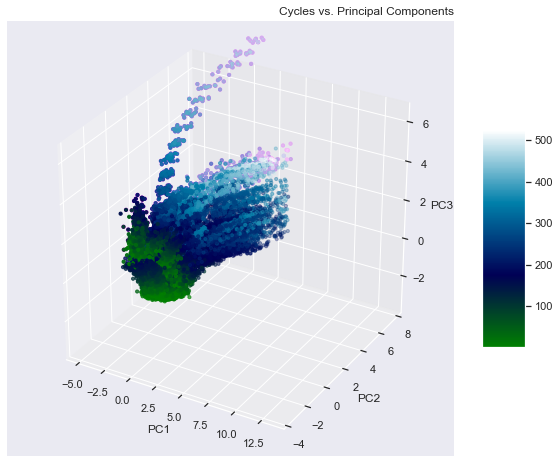

In [24]:
"""
Indicating best 5 performing engines (with a magenta mask) based on number of cycles
colored in magenta seen faintly towards top of plots towards PC3 in the same graph below
"""

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'],
    zdir='x', s = 10, c = X_train['cycle'],
    cmap = 'ocean', depthshade=True)

# make a mask for the most reliable engines [110, 118, 124, 134, 155] 
mask= ((Y_engine_id['engine_id'] == 110) | (Y_engine_id['engine_id'] == 118) | (Y_engine_id['engine_id'] == 124)| (Y_engine_id['engine_id'] == 134)| (Y_engine_id['engine_id'] == 155))

color_dict = {110: 'magenta', 118: 'magenta', 124: 'magenta', 134 : 'magenta',  155 : 'magenta'}
color_map = [color_dict[i] for i in Y_engine_id[mask]['engine_id']]

ax.scatter(Y_engine_id[mask]['PC1'], Y_engine_id[mask]['PC2'], Y_engine_id[mask]['PC3'], s = 10, c = color_map, zdir='x')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("Cycles vs. Principal Components", loc ='right')
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()



#### Magenta dots shows regions around which the best engines fluctuate with relatively high PC2 values and expectedly even higher PC3 values.  There appears to be minimal variation along the PC1 component for these high performing engines

#### Plot of Total Pressure HPC outlet against Principal Componnents

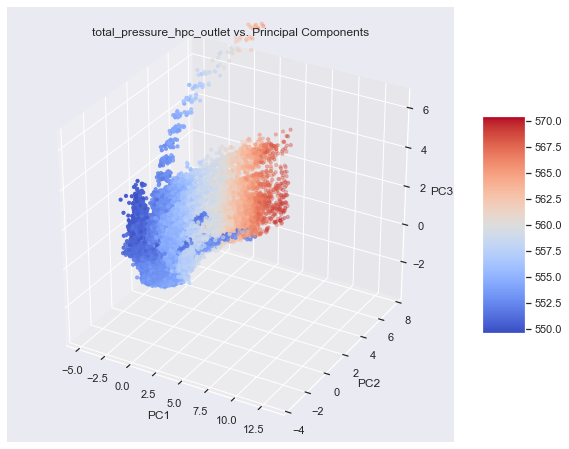

Text(1.0, 1.0, "'total_pressure_hpc_outlet' vs. Principal Components")

In [25]:
# Plot of Total Pressure HPC outlet against Principal Componnents

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'],
    zdir='x', s = 10, c = X_train['total_pressure_hpc_outlet'],
    cmap = 'coolwarm', depthshade=True)
ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("total_pressure_hpc_outlet vs. Principal Components")
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()
ax.set_title("'total_pressure_hpc_outlet' vs. Principal Components", loc ='right')

In [ ]:
"""Still anaylyzing how 5 top Engines with the best Time to Failure results having the highest number of cycles obtained from tranining data
fit into the total_pressure_hpc_outlet
"""
Engine 110
Engine 118
Engine 124
Engine 134
Engine 155*
"""

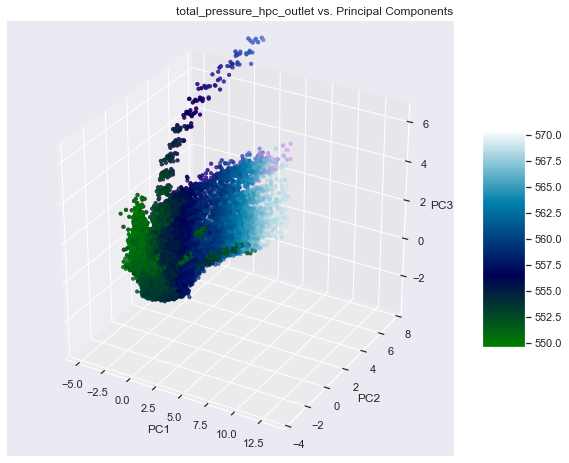

In [26]:
"""
Indicating best 5 performing engines (with a magenta mask) based on total_pressure_hpc_outlet
colored in magenta seen faintly towards top of plots towards PC3 in the same graph below
"""

fig = plt.figure(figsize = (10,8))
ax = fig.add_subplot(111, projection='3d')
p = ax.scatter(
    Y['PC1'], Y['PC2'], Y['PC3'],
    zdir='x', s = 10, c = X_train['total_pressure_hpc_outlet'],
    cmap = 'ocean', depthshade=True)

# make a mask for the most reliable engines [110, 118, 124, 134, 155] 
mask= ((Y_engine_id['engine_id'] == 110) | (Y_engine_id['engine_id'] == 118) | (Y_engine_id['engine_id'] == 124)| (Y_engine_id['engine_id'] == 134)| (Y_engine_id['engine_id'] == 155))

color_dict = {110: 'magenta', 118: 'magenta', 124: 'magenta', 134 : 'magenta',  155 : 'magenta'}
color_map = [color_dict[i] for i in Y_engine_id[mask]['engine_id']]

ax.scatter(Y_engine_id[mask]['PC1'], Y_engine_id[mask]['PC2'], Y_engine_id[mask]['PC3'], s = 10, c = color_map, zdir='x')

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_zlabel("PC3")
ax.set_title("total_pressure_hpc_outlet vs. Principal Components", loc ='right')
fig.colorbar(p, shrink=0.5, aspect=5)
plt.show()


# K-Means

In [28]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

processed_data=pca.fit_transform(X_train_std)

df_3=pd.DataFrame(processed_data,columns=['PCA1','PCA2','PCA3'])





In [29]:
from sklearn.cluster import KMeans
# use k means with 4 clusters and get the centroid for each cluster
cluster=KMeans(n_clusters=4)
cluster.fit(df_3)
result=cluster.predict(df_3)
center=cluster.cluster_centers_
result_df=pd.DataFrame(center,columns=['PCA1','PCA2','PCA3'])
result_df

,PCA1,PCA2,PCA3
0,4.008358,-0.520961,0.534447
1,-2.377020,-0.194622,0.254347
2,0.059135,6.893183,-0.140161
3,0.419819,-0.730969,-0.430615


### 3-D cluster plot

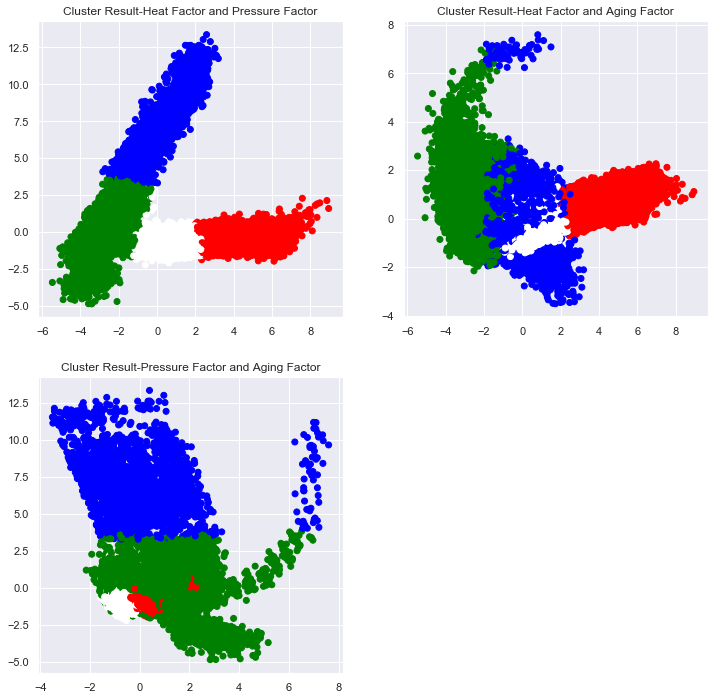

[1 3 3 ... 0 0 0]


In [30]:
import numpy as np
import matplotlib.pyplot as plt
#plot the clusters in the PCA space, marking cluster 0 as red, 1 as green, 2 as blue and 3 as white



plt.figure(figsize=(12, 12))

color= []
for l in result:
    if l==0:
        color.append('red')
    elif l==1:
        color.append('green')
    elif l==2:
        color.append('blue')
    else:
        color.append('white')

plt.subplot(221)
plt.scatter(df_3['PCA1'].values, df_3['PCA2'], c=color)
plt.xlabel=('Heat Factor')
plt.ylabel=('Pressure Factor')
plt.title("Cluster Result-Heat Factor and Pressure Factor")

plt.subplot(222)
plt.scatter(df_3['PCA1'].values, df_3['PCA3'], c=color)
plt.xlabel=('Heat Factor')
plt.ylabel=('Aging Factor')
plt.title("Cluster Result-Heat Factor and Aging Factor")


plt.subplot(223)
plt.scatter( df_3['PCA3'],df_3['PCA2'].values, c=color)
plt.ylabel=('Aging Factor')
plt.xlabel=('Pressure Factor')
plt.title("Cluster Result-Pressure Factor and Aging Factor")





plt.show()

print(result)

In [ ]:
### clustering algorithm randomly assigns cluster number each time. The result above is different from the one in the report
### cluster result that matches the one in the report is included in a seperate file. 
###

### accuracy test

In [31]:
#let the cluster result match the actual group label and test the accuracy of the result.

a=[]
for l in result:
    if l==0:
        a.append(3)
    elif l==1:
        a.append(3)
    elif l==2:
        a.append(1)
    else:
        a.append(2)



from sklearn.metrics import accuracy_score
print(accuracy_score(y_train,a))

0.5067363453948094


Credits: Dataset & EDA 
Salman, J., Aymen, D., Aymen, M and Ahmed A
https://github.com/adabghi/Predictive-maintenance-for-aircraft-engines/blob/master/aircraft_starting_kit.ipynb